# Introduction

This is my first thorough Exploratory Data Analysis. Because of this, it is very wild and messy. Also I went back to this notebook a few times to try new things, which I inserted without trying to keep the flow of the EDA coherent.

The subject of the EDA is the Housing dataset from the Kaggle competition\*. The goal was to get some experience about the EDA part of a machine learning project. In the next notebook (*Housing Model*), I built a model to predict the price of the house from the test set of the Kaggle competition.


\**https://www.kaggle.com/c/house-prices-advanced-regression-techniques*

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#loading the dataset
housing = pd.read_csv('data/house-prices-advanced-regression-techniques/train.csv', index_col=0)
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 1. Quick overview of the data

Before the EDA, I do a quick overview of the variables and assign them to the level of relationship I think they will have with the SalePrice. This will give a first starting point about what variables should we particularly examine later on.

In [3]:
# loading my quick overview of the variables, with my predicted importance 
# of the relationship with SalePrice
pre_analysis = pd.read_csv('Housing_analysis.csv')
pre_analysis.head()

,Variable,Type,Segment,Expectation,Conclusion,Comments
0,MSSubClass,cat,building,medium,NaN,aggregate other information
1,MSZoning,cat,location,medium,NaN,NaN
2,LotFrontage,num,space,low,NaN,NaN
3,LotArea,num,space,medium,NaN,NaN
4,Street,cat,space,low,NaN,NaN


In [4]:
# high expectation variables
high_expectation = pre_analysis.loc[pre_analysis.Expectation=='high', 'Variable']
medium_expectation = pre_analysis.loc[pre_analysis.Expectation=='medium', 'Variable']

print('# of medium expectation variables : {}'.format(len(medium_expectation)))
print('# of high expectation variables : {}'.format(len(high_expectation)))
high_expectation

# of medium expectation variables : 40
# of high expectation variables : 10


11    Neighborhood
16     OverallQual
17     OverallCond
26       ExterQual
27       ExterCond
30        BsmtCond
32    BsmtFinType1
37     TotalBsmtSF
45       GrLivArea
53    TotRmsAbvGrd
Name: Variable, dtype: object

### Quick overview of missing values

Before continuing and beginning the EDA, I will do a quick check of the missing values to potentially drop variables with too much missing values. This could save us time later on, by not analyzing variables who are useless because of their too large portion of missing values.

Before counting the nan values for each variables, we need to make sure that there isn't nan values which actually have a meaning. Sometimes, nan values doesn't mean absence of information.
For example, in the data_description.txt file, we learn that for the Alley variable, a nan value means there is no alley ! It's different from the case where there is no measure about the presence of an alley.
So, we can for the alley variable, change every nan to a new category (for example nan-> 'no alley'). Unfortunately, there may be some nan values, hidden in there, which actually comes from the absence of information.

The best we can do, is trying to choose if the majority of the nan are absence of information or a category in itself, by looking at the information we have in the data_description.txt file.

In [5]:
# quick look at nan count for each variable
null_count = housing.isnull().sum().sort_values(ascending=False)
null_count = null_count[null_count!=0]
null_pct = (null_count/len(housing)*100).round(2)
pd.concat([null_count, null_pct],axis=1).rename(columns={0:'count', 1:'pct'})

,count,pct
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageCond,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55


Some variables have a huge amount of missing values, we need to check if their respective nan values are information or lack of information.

### "False" Nans
From the data_description.txt file, we actually learn that for the majority of the variables with nan values, the nans mean absence of X, for example, for the PoolQC variable, a nan means that there is no pool.

list of those variables : PoolQC, Alley, Fence, FireplaceQu, GarageType, GarageCond, GarageFinish, GarageQual, GarageYrBlt, BsmtFinType2, BsmtExposure, BsmtQual, BsmtCond, BsmtFinType1, MasVnrArea, MasVnrType



### "Real" Nans
For the last two variables showing some nan values, Electrical and LotFrontage, all the nans represent the absence of information. We will have to choose later what to do with them.

In [6]:
false_nan_cols = [col for col in null_count.index if col not in ['LotFrontage', 'Electrical']]

def false_nan_to_cat(df, cols=false_nan_cols):
    '''
    change nan values for the column in the list cols to the value 'None'
    '''
    for col in cols:
        df.loc[df[col].isnull(), col] = 'None'
    
    return df

In [7]:
# let's check our nan values now
df = false_nan_to_cat(housing)

# quick look at nan count for each variable
null_count = df.isnull().sum().sort_values(ascending=False)
null_count = null_count[null_count!=0]
null_pct = (null_count/len(housing)*100).round(2)
pd.concat([null_count, null_pct],axis=1).rename(columns={0:'count', 1:'pct'})

,count,pct
LotFrontage,259,17.74
Electrical,1,0.07


# 2. EDA 
Now, let's get some insight from the data using visual methods.

## 2.1 Distribution of the SalePrice variable

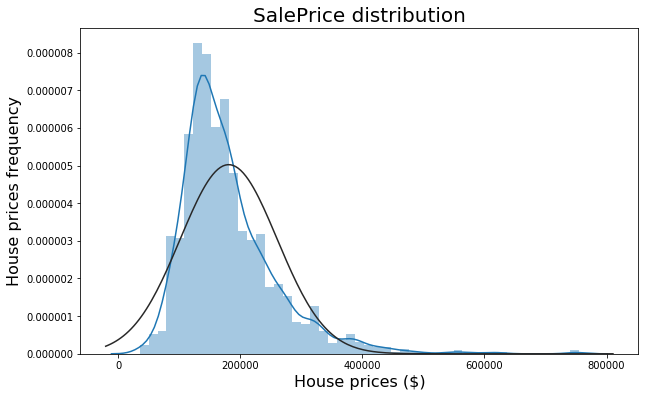

In [8]:
plt.figure(figsize=(10,6))
ax = sns.distplot(df.SalePrice, fit=stats.norm)
ax.set_xlabel('House prices ($)', fontsize=16)
ax.set_ylabel('House prices frequency', fontsize=16)
ax.set_title('SalePrice distribution', fontsize=20);

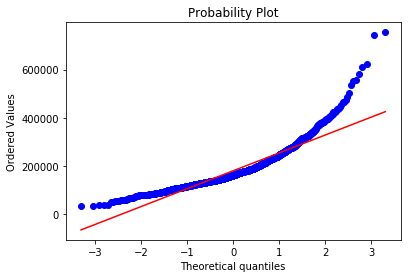

In [9]:
stats.probplot(df['SalePrice'], plot=plt);

We can see that the distribution is positively skewed and more peaked than the normal distribution, we also have some high value outliers.

We can investigate a bit more how far from normality the distribution is with the measure of skewness and kurtosis :

In [10]:
skew = df.SalePrice.skew()
kurt = df.SalePrice.kurt()
print('Skewness : %.2f' % skew)
print('Kurtosis : %.2f' % kurt)

Skewness : 1.88
Kurtosis : 6.54


The positive skew confirm the positive skew shown on the histogram. The positive kurtosis is telling us that the distribution is more peaked than the normal distribution.

We can also evaluate a z-score from these values*, to do a statistic test about how far from normality the distribution is.

\* *Source : Multivariate Data Analysis, Hair J. et. al.*

In [11]:
n_saleprice = df.SalePrice.count()
z_skew = skew/np.sqrt(6/n_saleprice)
z_kurt = kurt/np.sqrt(24/n_saleprice)
print(z_skew, z_kurt)

29.3712525128 50.9802051491


These z score are huge, due to the large number of measure available on the dataset. No need to calculate the p-value, with z score like those, the p-values will be extremely small. 

But... as an exercise, let's do it.

In [12]:
p_skew = 1-stats.norm.cdf(z_skew)
p_kurt = 1-stats.norm.cdf(z_kurt)
print('p-value for z_skew : %f' % p_skew)
print('p-value for z_kurt : %f' % p_kurt)

p-value for z_skew : 0.000000
p-value for z_kurt : 0.000000


To get a distribution more normal, we can apply the transformation y -> log(y+1) (the +1 is to avoid getting nans values in case of y=0, wich should not happens, but as good practice...)

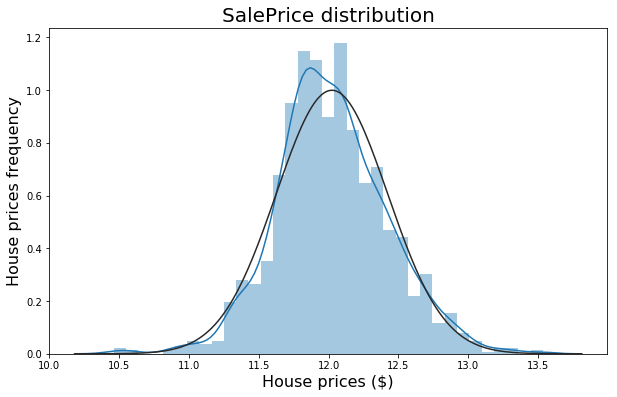

In [13]:
plt.figure(figsize=(10,6))
SalePrice_Log = np.log1p(df.SalePrice)
ax = sns.distplot(SalePrice_Log, fit=stats.norm)
ax.set_xlabel('House prices ($)', fontsize=16)
ax.set_ylabel('House prices frequency', fontsize=16)
ax.set_title('SalePrice distribution', fontsize=20);

In [14]:
skew = SalePrice_Log.skew()
kurt = SalePrice_Log.kurt()
print('Skewness : %.2f' % skew)
print('Kurtosis : %.2f' % kurt)

Skewness : 0.12
Kurtosis : 0.81


Much better !

# 3. Relationships of the explanatory variables with SalePrice

## 3.1 Numerical variables

We will begin by analyzing the relationship of SalePrice with the numerical variables. For this task, the scatterplot and pearson correlation coefficient will be our main tools.

First, we will restrict our EDA to numeric variables with high or medium expectation, to reduce the variables number.

In [15]:
# select columns with high or medium expectation as good predictor for SalePrice
high_medium_cols = pre_analysis.loc[pre_analysis.Expectation.isin(['high', 'medium']), 'Variable']

# select numeric columns
num_cols = df[high_medium_cols].select_dtypes(['number']).columns

# count number of columns which are numerci or categorical
df[high_medium_cols].dtypes.value_counts()

object    29
int64     21
dtype: int64

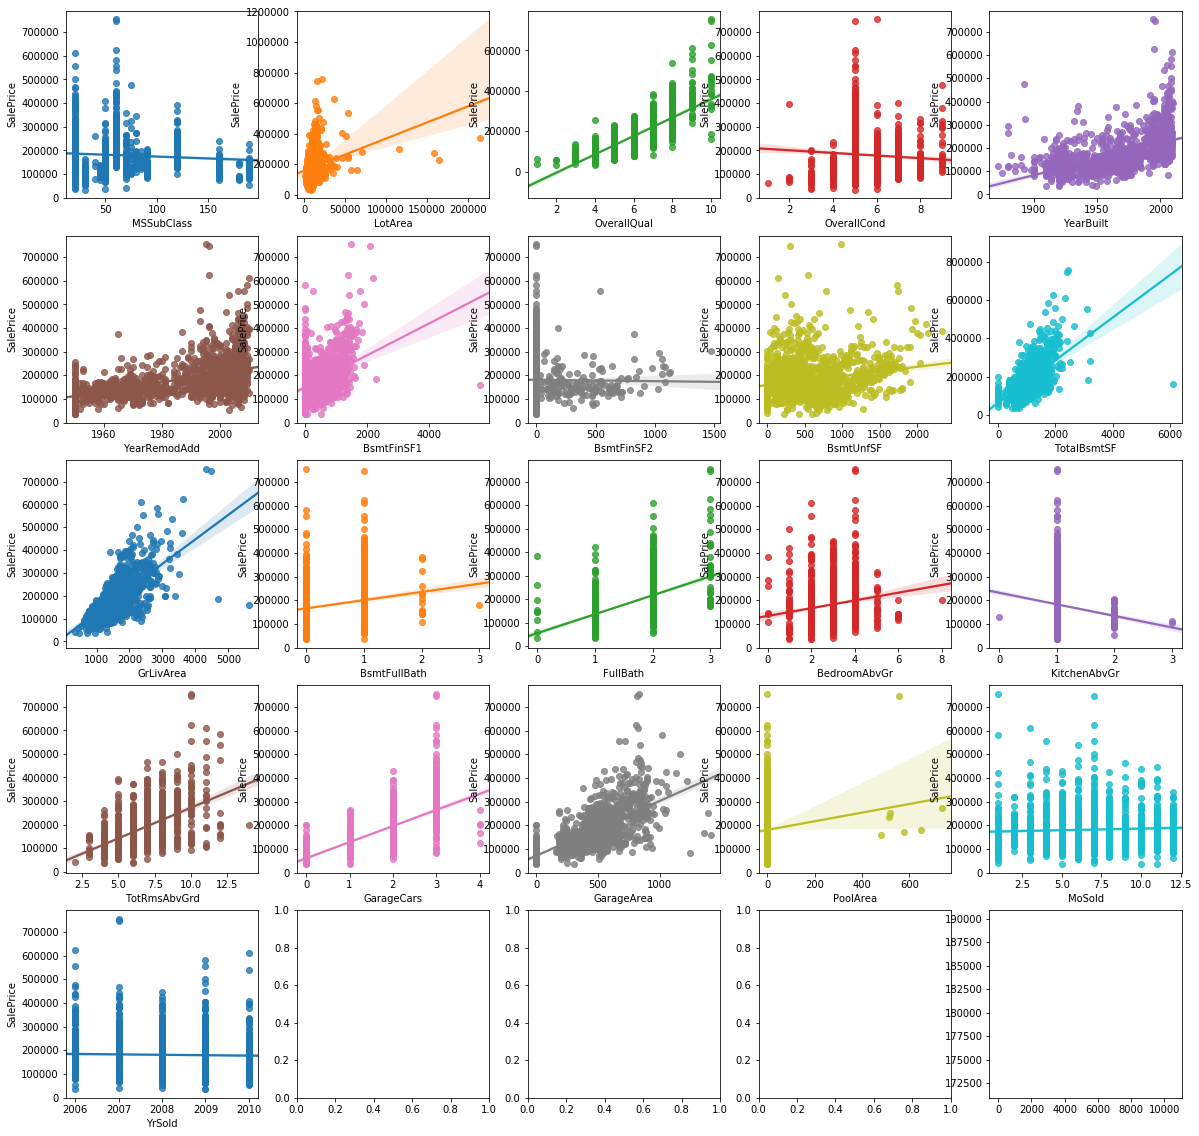

In [16]:
# scatter plot of high and medium variables, with the SalePrice variable
n_cols = len(num_cols)

fig, axes = plt.subplots(n_cols//5+1, 5, figsize=(20,20))

for ax, col in zip(axes.flatten(), num_cols):
    sns.regplot(col, 'SalePrice', data=df, ax=ax)

These scatter plot let us see quickly which variable shows an interesting relationship with the SalePrice variable.
Now, we will compute the correlation coefficient to help us decide which variables are good predictor candidates. We also see that MSSubClass should be treated as a categorical variable, rather than numerical

Now, let's see the correlation values, ordered by their absolute value.

In [17]:
cols = np.append('SalePrice', num_cols)
corr_df = df[cols].corr()
corr_w_SalePrice = corr_df.SalePrice
corr_w_SalePrice_abs = corr_w_SalePrice.abs().sort_values(ascending=False)
high_corr_cols = corr_w_SalePrice.loc[corr_w_SalePrice_abs.index]
high_corr_cols

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
BsmtFinSF1      0.386420
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
KitchenAbvGr   -0.135907
PoolArea        0.092404
MSSubClass     -0.084284
OverallCond    -0.077856
MoSold          0.046432
YrSold         -0.028923
BsmtFinSF2     -0.011378
Name: SalePrice, dtype: float64

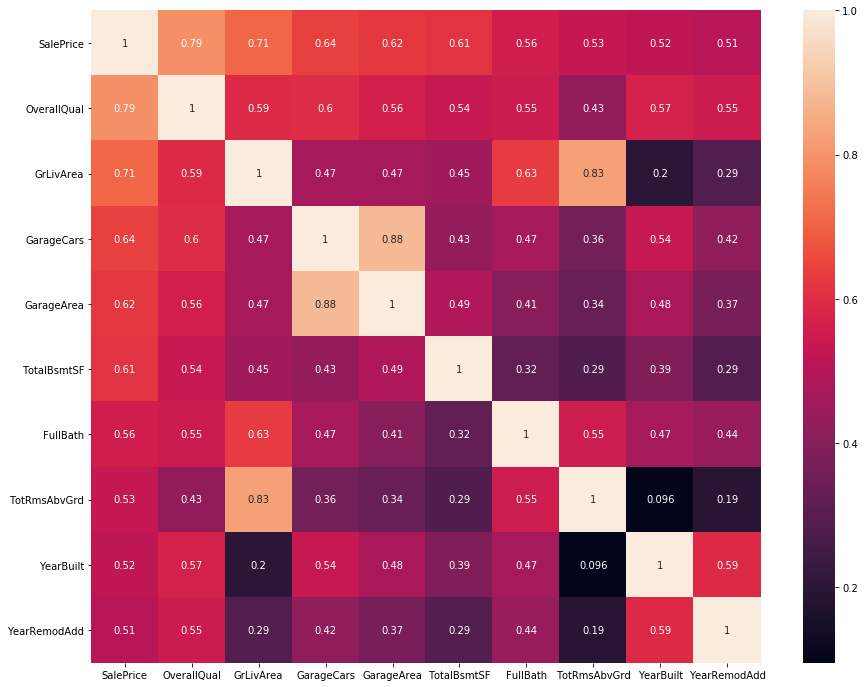

In [18]:
# correlation matrix for the columns having the highest correlation with SalePrice
cols = high_corr_cols.loc[high_corr_cols.abs()>0.5].index

corr_df = df[cols].corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr_df,annot=True);

This heatmap let us see easily which couple of variables shows the highes level of **linear** relationship. We can see now which variables will make a good predictor for the SalePrice.
But, we should also pay attention to which predictors show a high colinearity, because multiple predictors with high colinearity would not be as good for predicting SalePrice than multiple predictors with a weak colinearity. The explanation is that if two predictors have high colinearity, they will explain the same portion of variance for SalePrice (one of the predictors may be redundant).

So, we see that the couples (GrLivArea, TotRmsAbvGrd) and (GarageArea, GarageCars) show a high linear relationships, which is not surprising. We can choose to drop the variable of each couple showing the lowest linear relationship with SalePrice.

What we must also pay attention to, is if we are not missing any important variables showing a non-linear relationships with SalePrice, or if any outliers who may have lowered the correlation coefficient computed before.
For that we can use the scatterplots from earlier.

* **OverallQual** seems to show a non-linear relationships with SalePrice, let's investigate

In [19]:
r1 = stats.pearsonr(df.SalePrice,df.OverallQual)[0]
r2 = stats.pearsonr(df.SalePrice,df.OverallQual.pow(2))[0]
r1, r2

(0.79098160058380507, 0.81716844361288488)

We see a slightly better correlation for the OverallQual^2 variables, it is a promising transformation to keep in mind.

* **YearBuilt, YearRemodAdd** seems to show a non-linear relationships with SalePrice, let's investigate

In [20]:
year_built = df.YearBuilt - df.YearBuilt.min()
r1 = stats.pearsonr(df.SalePrice,year_built)[0]
r2 = stats.pearsonr(df.SalePrice,year_built.pow(2))[0]
r1, r2

(0.52289733287949691, 0.56354395628101495)

In [21]:
Year_Remod_Add = df.YearRemodAdd - df.YearRemodAdd.min()
r1 = stats.pearsonr(df.SalePrice,Year_Remod_Add)[0]
r2 = stats.pearsonr(df.SalePrice,Year_Remod_Add.pow(2))[0]
r1, r2

(0.50710096711138608, 0.50935461728711517)

**YearBuilt** shows an higher correlation when squared, no improvement for **YearRemodAdd** tough.

* **BsmtFinSF1** shows some potential on the scatterplot despite the low correlation value (0.38), but it seems that the correlation is so low due to some outliers, let's see if dropping them improve significately the correlation value.

In [22]:
df_no_outlier = df.loc[(df.BsmtFinSF1<4000)]
r1 = stats.pearsonr(df.SalePrice, df.BsmtFinSF1)[0]
r2 = stats.pearsonr(df_no_outlier.SalePrice, df_no_outlier.BsmtFinSF1)[0]
r3 = stats.pearsonr(df_no_outlier.SalePrice, df_no_outlier.BsmtFinSF1.pow(2))[0]
r1,r2,r3

(0.38641980624215327, 0.40705980393663749, 0.50430652123701147)

removing the outlier and squaring the **BsmtFinSF1** shows a high improvement of the correlation, this variable is now a good predictor candidate.

The list of variables with a good significant linear relationship with SalePrice :

In [23]:
num_pred_cols = high_corr_cols.loc[high_corr_cols>0.5]
num_pred_cols = num_pred_cols.drop(['TotRmsAbvGrd', 'GarageArea'])

num_pred_cols.loc['BsmtFinSF1_no_outlier_sq'] = stats.pearsonr(df.SalePrice,Year_Remod_Add.pow(2))[0]
num_pred_cols.loc['OverallQual_sq'] = stats.pearsonr(df.SalePrice,df.OverallQual.pow(2))[0]
num_pred_cols.loc['year_built_sq'] =stats.pearsonr(df.SalePrice,year_built.pow(2))[0]

num_pred_cols = num_pred_cols.sort_values(ascending=False)
num_pred_cols

SalePrice                   1.000000
OverallQual_sq              0.817168
OverallQual                 0.790982
GrLivArea                   0.708624
GarageCars                  0.640409
TotalBsmtSF                 0.613581
year_built_sq               0.563544
FullBath                    0.560664
YearBuilt                   0.522897
BsmtFinSF1_no_outlier_sq    0.509355
YearRemodAdd                0.507101
Name: SalePrice, dtype: float64

### Outliers

Now, we replot the scatter plot of these variables with SalePrice to visually detect important outliers and check if there is some non-linear relationships.

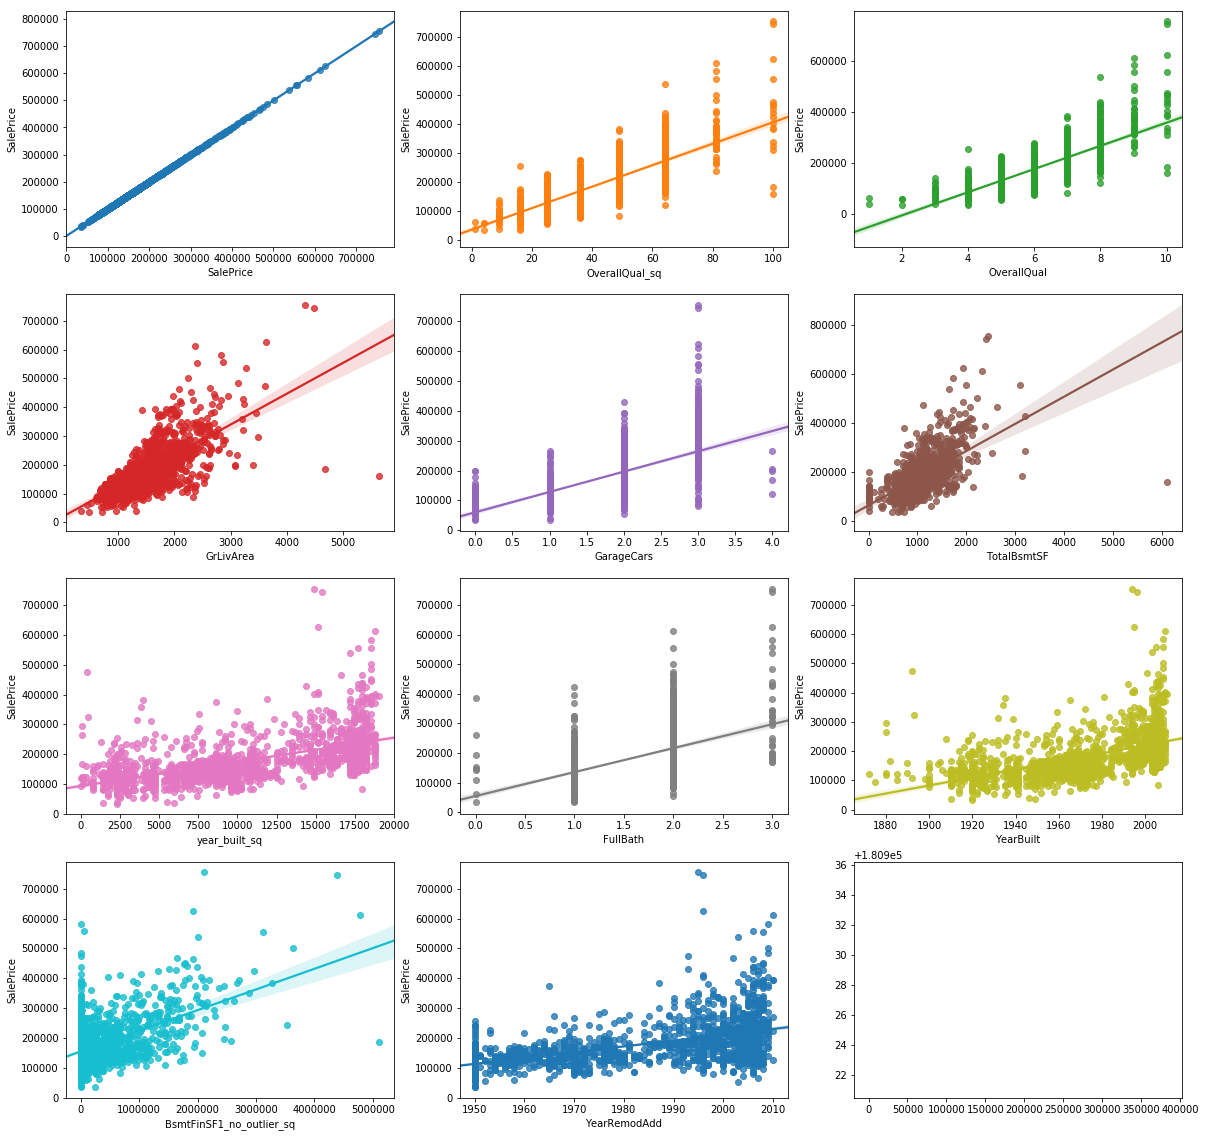

In [24]:
# pairplot of best predictor candidates 
df2 = df[[col for col in num_pred_cols.index if col in df.columns]].copy()

df2['OverallQual_sq'] = df['OverallQual'].pow(2)
df2['year_built_sq'] = (df.YearBuilt - df.YearBuilt.min()).pow(2)

df2['BsmtFinSF1_no_outlier_sq'] = df['BsmtFinSF1']
df2.loc[df2['BsmtFinSF1_no_outlier_sq']>4000, 'BsmtFinSF1_no_outlier_sq'] = np.nan
df2['BsmtFinSF1_no_outlier_sq'] = df2['BsmtFinSF1_no_outlier_sq'].pow(2)

n_cols = len(num_pred_cols.index)
fig, axes = plt.subplots(n_cols//3+1, 3, figsize=(20,20))

for ax, col in zip(axes.flatten(), num_pred_cols.index):
    sns.regplot(col, 'SalePrice', data=df2, ax=ax)

This last look at the scatter plot let us think that **GarageCars** and **FullBath** may be better predictor if squared. **YearBuilt** may also benefit of being elevated to a higher order than 2.

Some outliers are clearly visible on the plot of GrLivArea with SalePrice, let's identify them.

524
692
1183
1299


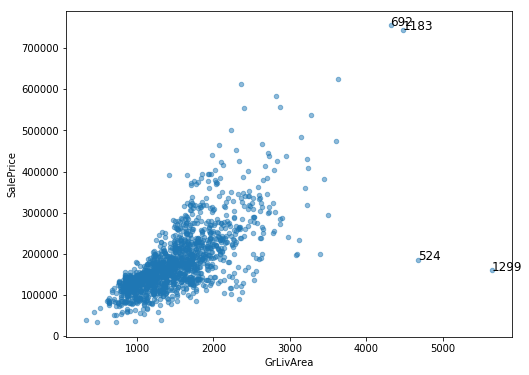

In [25]:
df.plot.scatter('GrLivArea', 'SalePrice', alpha=0.5, figsize=(8,6))
for i in df.index:
    if (df.GrLivArea.at[i] > 4000) :
        plt.text(df.GrLivArea.at[i], df.SalePrice.at[i], str(i), fontsize=12)
        print(i)

The house (of Id) 524 and 1299) should be removed, the 692 and 1183 seem to be coherent with the other points, but because of the large distance with the rest of the points, they may have a detrimental high leverage for the fit of the model. We scoose to keep them at first.

### 3.1.3 Transformation to a more normal distribution of numercial features

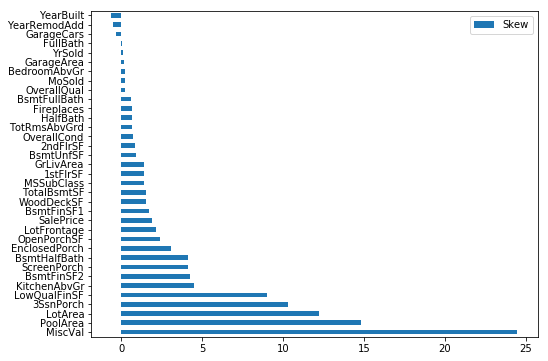

In [26]:
# Check the skew of all numerical features
skews = df.skew().sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skews})

skewness.plot(kind='barh', figsize=(8,6));

In [27]:
from scipy.special import boxcox1p
df2 = df.copy()

skewed_feats = skewness[abs(skewness) > 5]
print("There are ", len(skewed_feats),  "skewed numerical features to Box-Cox transform")

skewed_features = skewed_feats.index
lam = 0.5
for feat in skewed_features:
    df2[feat] = boxcox1p(df2[feat], lam)

There are  35 skewed numerical features to Box-Cox transform


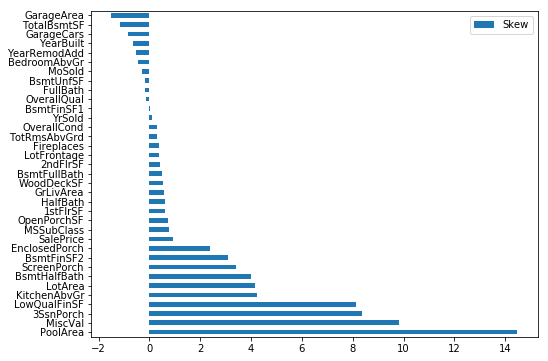

In [28]:
# Check the skew of all numerical features
skews = df2.skew().sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skews})

skewness.plot(kind='barh', figsize=(8,6));

## 3.2 Categorical variables

Now that we are done with numeric variables, let's see what categorical variables would make a good predictors.

First, we select the list of categorical variables

In [29]:
cat_cols = df[high_medium_cols].select_dtypes(['object']).columns
cat_cols

Index(['MSZoning', 'Utilities', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'PoolQC', 'SaleType', 'SaleCondition'],
      dtype='object')

It's quite a long list, what are our high expectation categorical variables ?

In [30]:
high_cols = pre_analysis.loc[pre_analysis.Expectation=='high','Variable']
high_cat_cols = df[high_cols].select_dtypes(['object']).columns
high_cat_cols

Index(['Neighborhood', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1'], dtype='object')

Let's begin to analyse these variables.

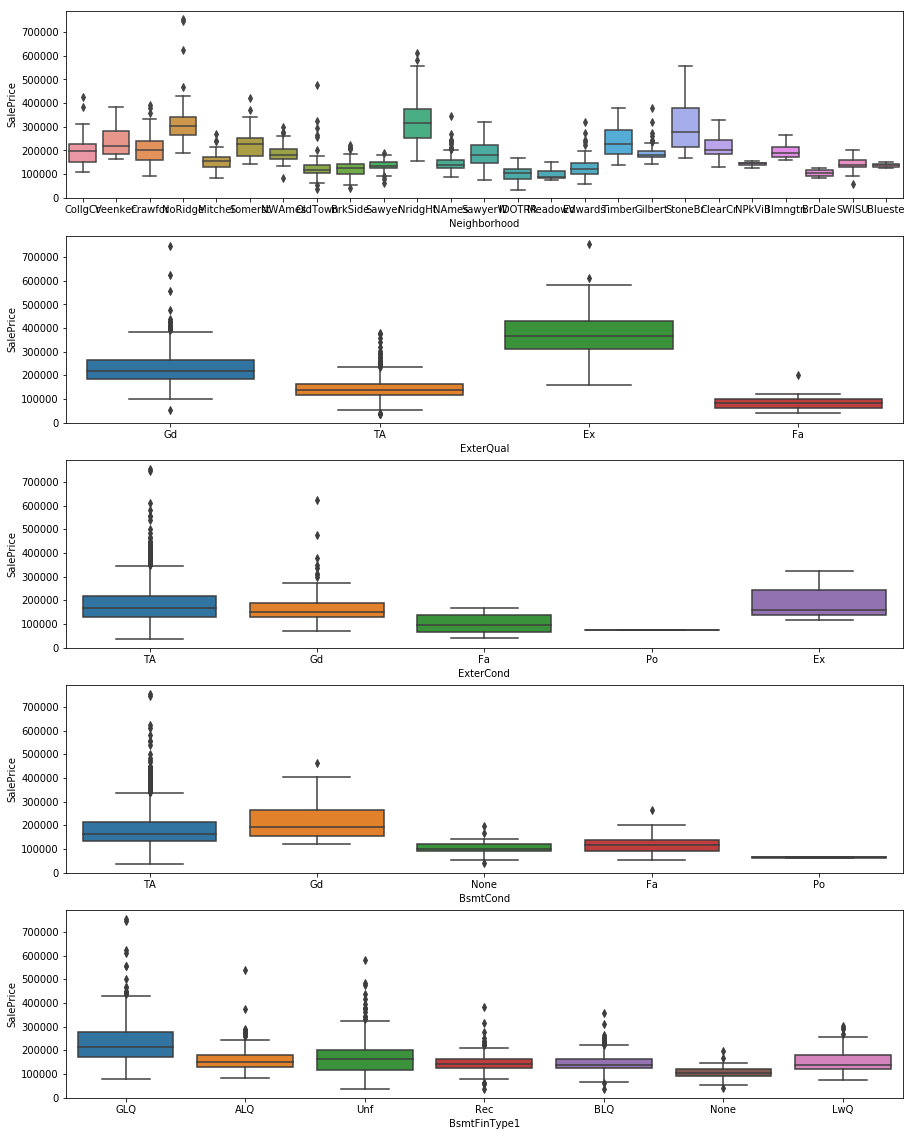

In [31]:
n_cols = len(high_cat_cols)

fig, axes = plt.subplots(n_cols, 1, figsize=(15,20))
for ax, col in zip(axes.flatten(), high_cat_cols):
    sns.boxplot(x=col, y='SalePrice', data=df, ax=ax)

So, what can we tell about those boxplot ? Well, a good categorical predictor would have significant difference for the mean of Saleprice across the different categorie, as well as having a small variance for each group. 
We can tell that the Neighborhood and ExterQual are from far, the best predictors.

What about the medium expectation categorical variables ?

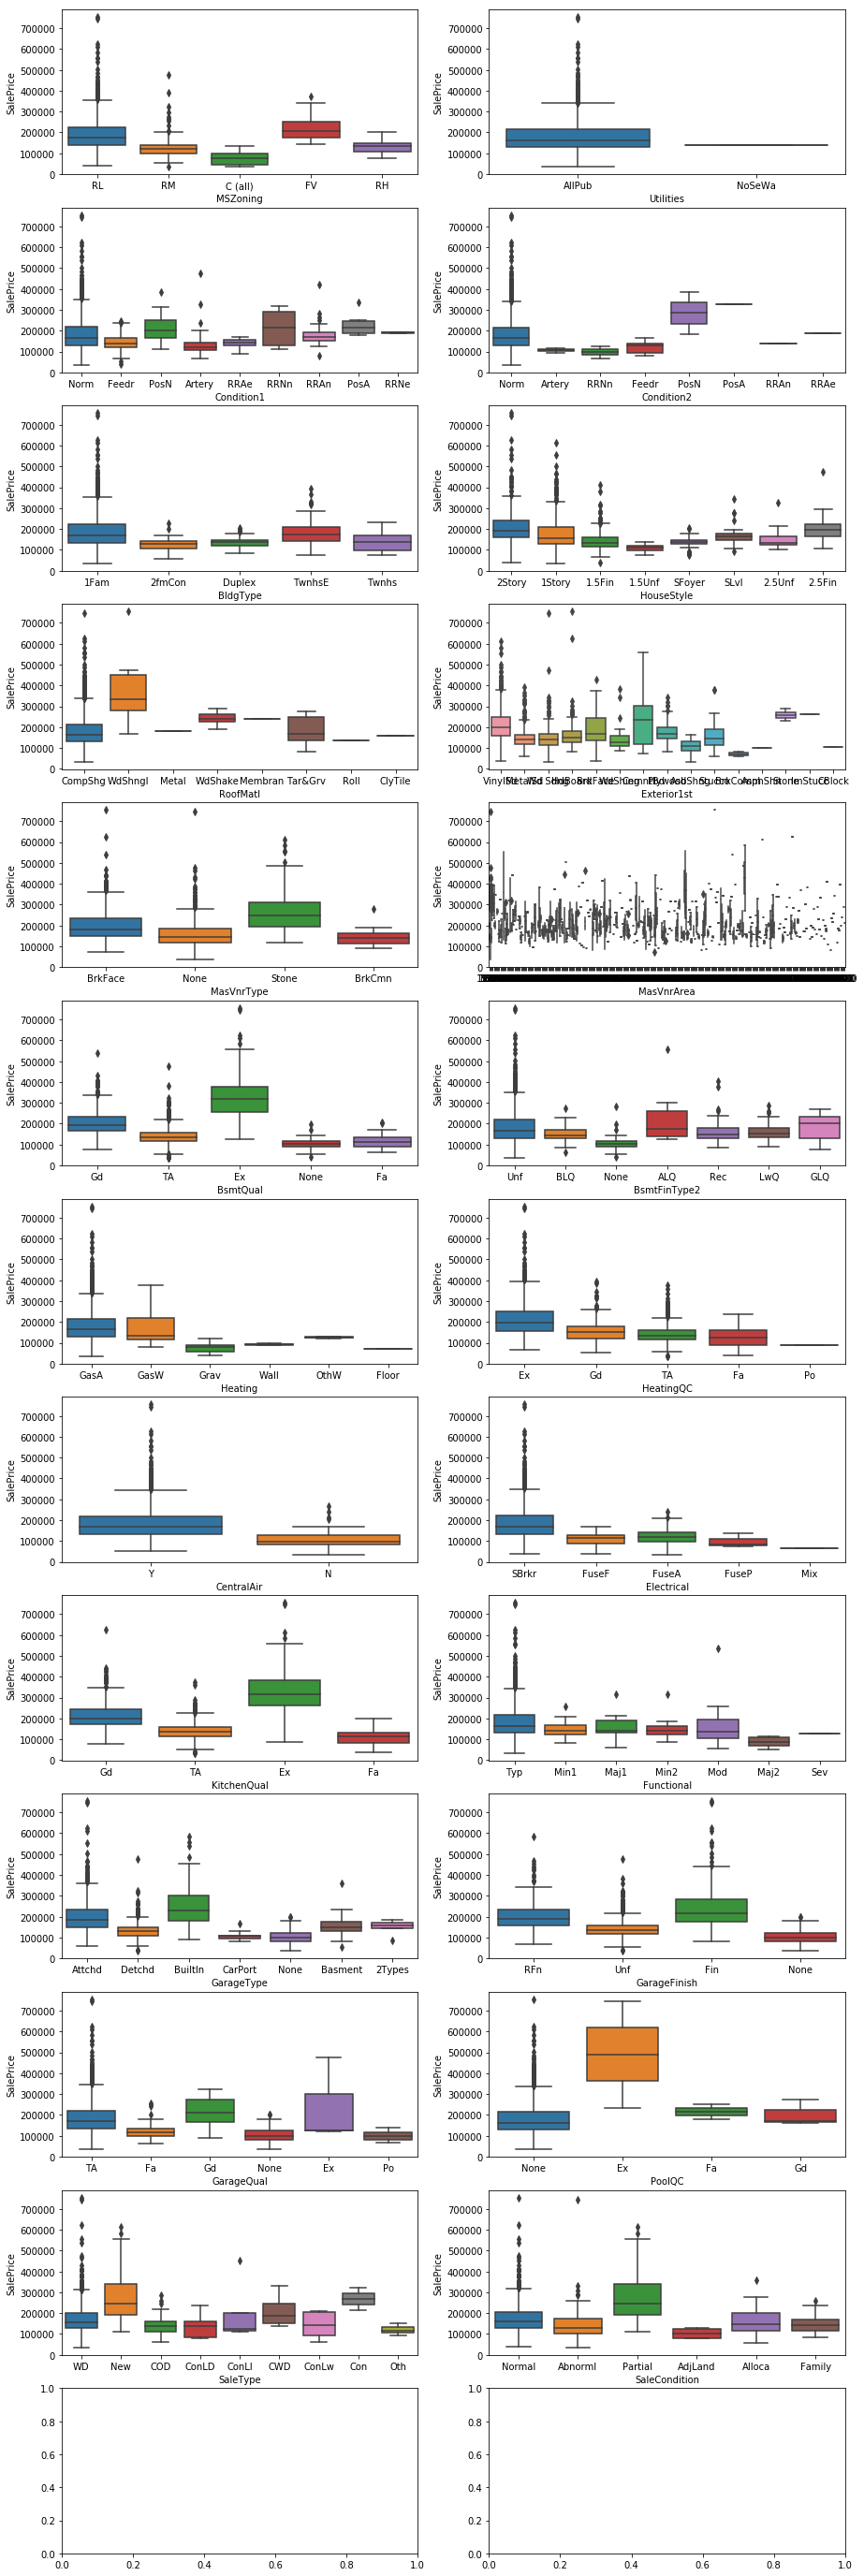

In [32]:
medium_cols = pre_analysis.loc[pre_analysis.Expectation=='medium','Variable']
medium_cat_cols = df[medium_cols].select_dtypes(['object']).columns
medium_cat_cols

n_cols = len(medium_cat_cols)

fig, axes = plt.subplots(n_cols//2+1, 2, figsize=(15,50))
for ax, col in zip(axes.flatten(), medium_cat_cols):
    sns.boxplot(x=col, y='SalePrice', data=df, ax=ax)

There is something weird, **MasVnrArea** is seen by pandas as a categorical column, which it shouldn't.

In [33]:
df.MasVnrArea.dtypes

dtype('O')

In [34]:
df.MasVnrArea.head()

Id
1    196
2      0
3    162
4      0
5    350
Name: MasVnrArea, dtype: object

Anyway, it's not a good predictor, so we don't care.

Now, we need to choose which categorical could be good predictor candidate, but I don't really have the expertise to make well justified choice for that. I will just take a subjective list of good candidate by looking at the previous boxplots and select those with the greatest variability between group while keeping a lowish variability within each groups.

I guess that doing an ANOVA test for each category and select the category with highest F-score would be a good indicator, let's try that.

In [35]:
pivot_df = df.pivot(columns='Neighborhood', values='SalePrice')

cols = pivot_df.columns
groups = []
for col in cols:
    groups.append(pivot_df[col].dropna())

F, p = stats.f_oneway(*groups)
F, p

(71.784865120582779, 1.5586002827707996e-225)

In [36]:
ANOVA_cat_cols = pd.DataFrame(columns=['F', 'p'])
for col in cat_cols:
    pivot_df = df.pivot(columns=col, values='SalePrice')

    group_cols = pivot_df.columns
    groups = []
    for group_col in group_cols:
        groups.append(pivot_df[group_col].dropna())

    F, p = stats.f_oneway(*groups)
    ANOVA_cat_cols.loc[col, 'F'] = F
    ANOVA_cat_cols.loc[col, 'p'] = p
    
ANOVA_cat_cols_sorted = ANOVA_cat_cols.sort_values(by='p')
ANOVA_cat_cols_sorted

,F,p
Neighborhood,71.7849,1.5586e-225
ExterQual,443.335,1.43955e-204
BsmtQual,316.149,8.15855e-196
KitchenQual,407.806,3.03221e-192
GarageFinish,213.867,6.22875e-115
GarageType,80.38,6.11703e-87
BsmtFinType1,64.6882,2.38636e-71
HeatingQC,88.3945,2.66706e-67
MasVnrType,108.911,1.2797e-63
MasVnrArea,3.49305,3.35059e-54


OK, all the p-value are super-low, that's not really helpfull, let'see the boxplots of the 5 variables with the lowest p-values.

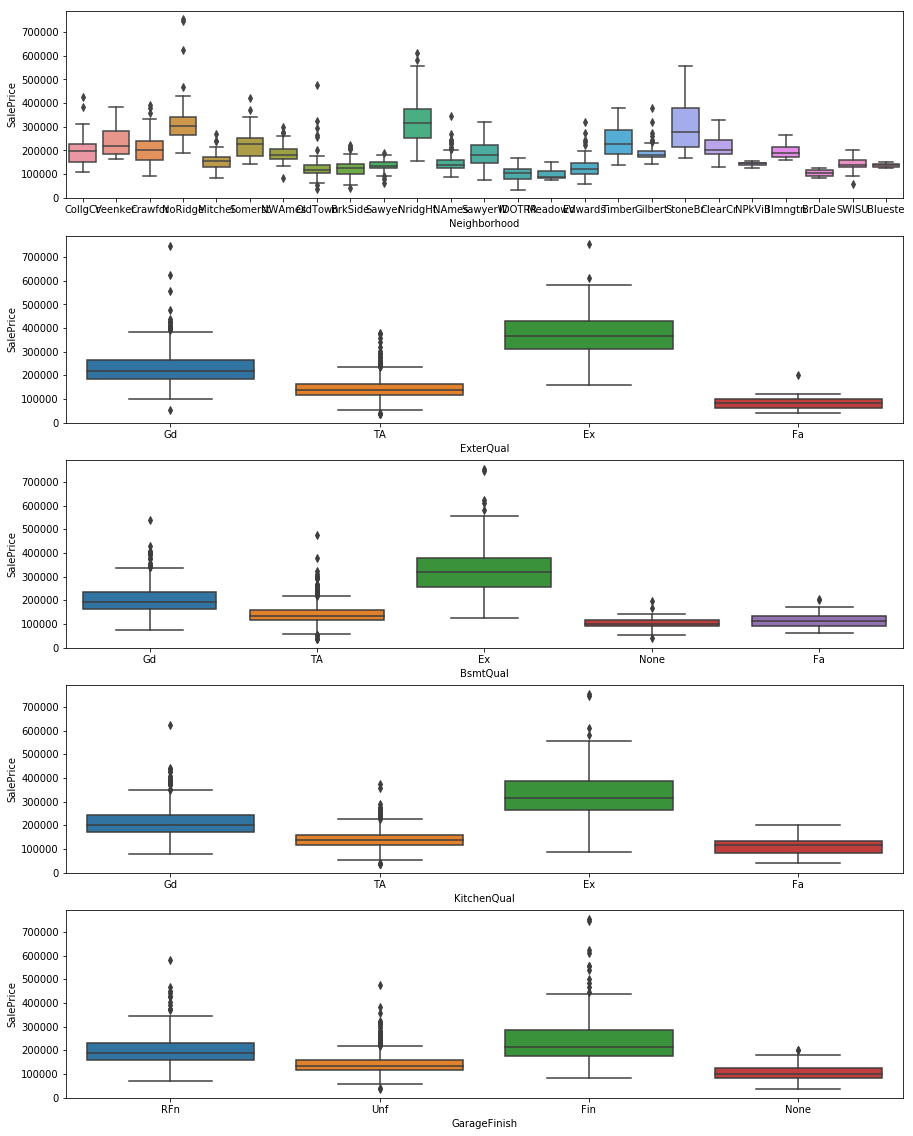

In [37]:
best_p_cols = ANOVA_cat_cols_sorted.head(5).index
n_cols = len(best_p_cols)

fig, axes = plt.subplots(n_cols, 1, figsize=(15,20))
for ax, col in zip(axes.flatten(), best_p_cols):
    sns.boxplot(x=col, y='SalePrice', data=df, ax=ax)

In [38]:
best_p_cols

Index(['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish'], dtype='object')

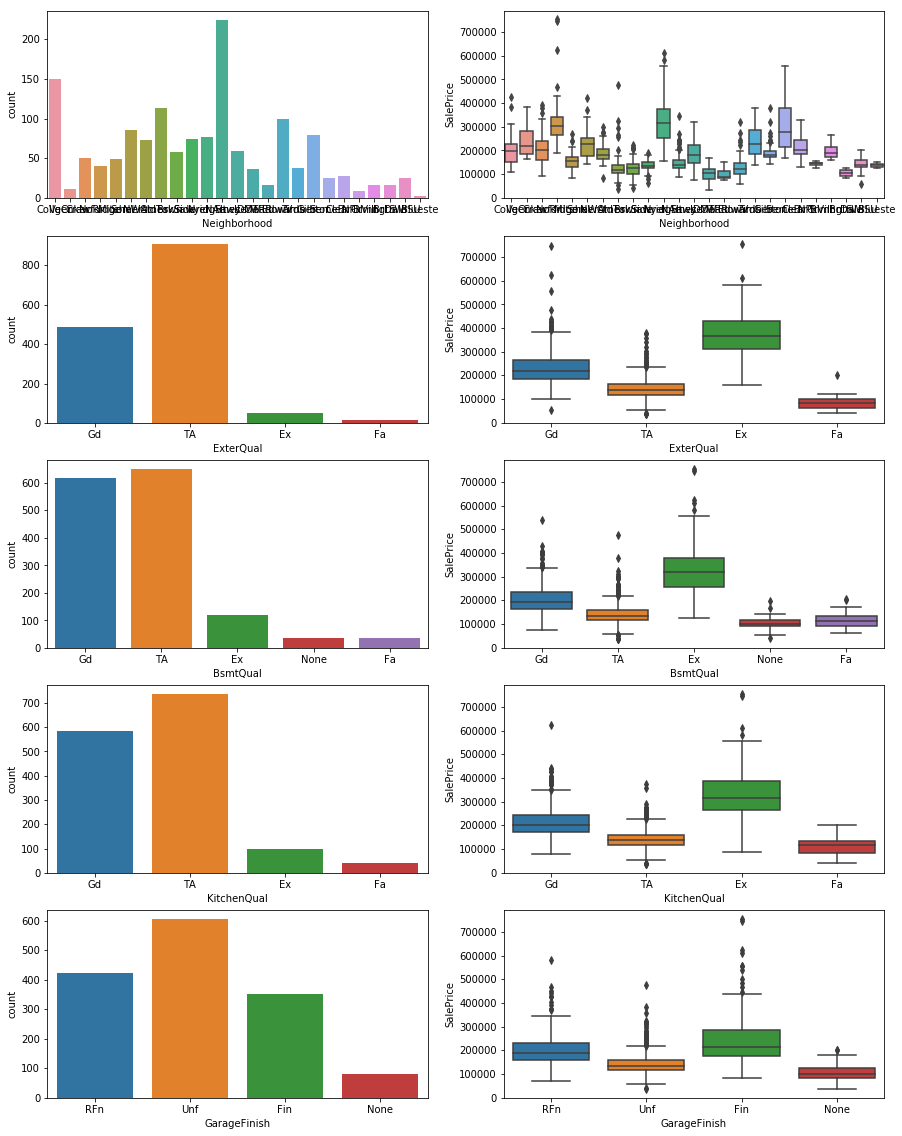

In [39]:
cols = best_p_cols
n_cols = len(best_p_cols)

fig, axes = plt.subplots(n_cols, 2, figsize=(15, 20))

for ax, col in zip(axes, cols):
    sns.countplot(col, data=df, ax=ax[0])
    sns.boxplot(x=col, y='SalePrice', data=df, ax=ax[1])